In [66]:
## In order to run this notebook, GEOPANDAS must be installed. If you are using anaconda, this can be done
## by running the following command in the anaconda promt: "conda install -c conda-forge geopandas"
## Alternatively with pip: "pip install git+git://github.com/geopandas/geopandas.git"

## Importing and naming


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pydst
dst = pydst.Dst(lang='en')


,REGIONKODE,REGIONNAVN,KOMKODE,KOMNAVN,Landsel,Landskode,geometry
0,1084,Region Hovedstaden,0400,Bornholm,Bornholm,8,"(POLYGON ((891187.49 6118170.25, 891186.3 6118..."
1,1085,Region Sjælland,0259,Køge,Østsjælland,7,"(POLYGON ((702347.24 6155011.31, 702342.570000..."
2,1085,Region Sjælland,0350,Lejre,Østsjælland,7,"(POLYGON ((684542.65 6171881.69, 684546.91 617..."
3,1085,Region Sjælland,0265,Roskilde,Østsjælland,7,"(POLYGON ((694011.6900000001 6183259.77, 69402..."
4,1085,Region Sjælland,0269,Solrød,Østsjælland,7,"(POLYGON ((703151.55 6157196.08, 703152.15 615..."


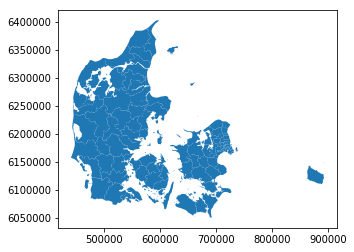

In [2]:
## KOM_MULTIPART.dbf , KOM_MULTIPART.shp and KOM_MULTIPART.shx must be placed 
## in the same folder as the saved notebook, in order for the code to work
## Read the GEO file
map_df = gpd.read_file("KOM_MULTIPART.shp")

## Plot the raw geodata
map_df.plot()

## Look the the structure of the geodata 
map_df.head()


In [3]:
## Look at the dataset FOD407

fod407_vars = dst.get_variables(table_id='FOD407')

fod407_vars

,elimination,id,map,text,time,values
0,True,OMRÅDE,denmark_municipality_07,region,False,"[{'id': '000', 'text': 'All Denmark'}, {'id': ..."
1,True,ALDER,NaN,age,False,"[{'id': 'TOT1', 'text': 'Total fertility rate'..."
2,False,Tid,NaN,time,True,"[{'id': '2006', 'text': '2006'}, {'id': '2007'..."


In [4]:
fod407_vars['values'][1][:] ## age= TOT1 to ONLY include all ages

[{'id': 'TOT1', 'text': 'Total fertility rate'},
 {'id': '15-19', 'text': '15-19 years'},
 {'id': '20-24', 'text': '20-24 years'},
 {'id': '25-29', 'text': '25-29 years'},
 {'id': '30-34', 'text': '30-34 years'},
 {'id': '35-39', 'text': '35-39 years'},
 {'id': '40-44', 'text': '40-44 years'},
 {'id': '45-49', 'text': '45-49 years'}]

In [36]:
## I load the fertility rate data via the API

fod407_raw = dst.get_data(table_id = 'FOD407', variables={'OMRÅDE':['*'], 'TID':['*'], 'ALDER':['TOT1'] })
fod407=fod407_raw.drop(['ALDER'], axis=1)
fod407.head()

,OMRÅDE,TID,INDHOLD
0,All Denmark,2006,1847.6
1,Region Hovedstaden,2006,1706.2
2,Region Sjælland,2006,2061.2
3,Region Syddanmark,2006,1928.0
4,Region Midtjylland,2006,1919.1


In [37]:
#I rename the used columns

fod407_en=fod407.rename(columns={"OMRÅDE": "AREA", "TID": "YEAR", "INDHOLD": "FertilityRate"})
fod407_en.head()

,AREA,YEAR,FertilityRate
0,All Denmark,2006,1847.6
1,Region Hovedstaden,2006,1706.2
2,Region Sjælland,2006,2061.2
3,Region Syddanmark,2006,1928.0
4,Region Midtjylland,2006,1919.1


In [38]:
# Adjusting geo-names to merge properly


fod407_en.loc[fod407_en.AREA=='Copenhagen', 'AREA'] = 'København'
fod407_en.loc[fod407_en.AREA=='Høje-Taastrup', 'AREA'] = 'Høje Taastrup'
fod407_en.head()

,AREA,YEAR,FertilityRate
0,All Denmark,2006,1847.6
1,Region Hovedstaden,2006,1706.2
2,Region Sjælland,2006,2061.2
3,Region Syddanmark,2006,1928.0
4,Region Midtjylland,2006,1919.1


In [39]:
## We would like to illustrate the data at the first and last year of our period - 2007 and 2017

fod407_en_2017=fod407_en[fod407_en['YEAR']==2017]   
fod407_en_2007=fod407_en[fod407_en['YEAR']==2007]


fod407_en_2017=fod407_en_2017.rename(columns={'FertilityRate': 'FertilityRate17'})
fod407_en_2007=fod407_en_2007.rename(columns={'FertilityRate': 'FertilityRate07'})
fod407_en_2007.head()

,AREA,YEAR,FertilityRate07
116,All Denmark,2007,1843.5
117,Region Hovedstaden,2007,1721.9
118,Region Sjælland,2007,1991.1
119,Region Syddanmark,2007,1955.6
120,Region Midtjylland,2007,1895.3


In [43]:
## I merge the fertility data on the geodata, first the 2017 data, next the 2007 data. We merge on municipal - geo levels
## other than municipal will not be included in the merge. 

merged = pd.merge(map_df, fod407_en_2017, how='left', left_on='KOMNAVN', right_on='AREA')
merged = pd.merge(merged, fod407_en_2007, how='left', left_on='KOMNAVN', right_on='AREA')
merged.head()


,REGIONKODE,REGIONNAVN,KOMKODE,KOMNAVN,Landsel,Landskode,geometry,AREA_x,YEAR_x,FertilityRate17,AREA_y,YEAR_y,FertilityRate07
0,1084,Region Hovedstaden,0400,Bornholm,Bornholm,8,"(POLYGON ((891187.49 6118170.25, 891186.3 6118...",Bornholm,2017,1837.7,Bornholm,2007,2105.2
1,1085,Region Sjælland,0259,Køge,Østsjælland,7,"(POLYGON ((702347.24 6155011.31, 702342.570000...",Køge,2017,1971.8,Køge,2007,2061.7
2,1085,Region Sjælland,0350,Lejre,Østsjælland,7,"(POLYGON ((684542.65 6171881.69, 684546.91 617...",Lejre,2017,2126.1,Lejre,2007,2552.5
3,1085,Region Sjælland,0265,Roskilde,Østsjælland,7,"(POLYGON ((694011.6900000001 6183259.77, 69402...",Roskilde,2017,1751.4,Roskilde,2007,1853.8
4,1085,Region Sjælland,0269,Solrød,Østsjælland,7,"(POLYGON ((703151.55 6157196.08, 703152.15 615...",Solrød,2017,2185.9,Solrød,2007,1881.8


In [45]:
# Does all geopoints have a fertility rate? Let's find out!!

missingrate17=merged[merged['FertilityRate17'] == '..']
missingrate07=merged[merged['FertilityRate07'] == '..']
print(missingrate17['AREA_x'])
print(missingrate07['AREA_x'])

20           Læsø
24          Samsø
40            Ærø
42           Fanø
54    Christiansø
Name: AREA_x, dtype: object
20           Læsø
24          Samsø
40            Ærø
42           Fanø
54    Christiansø
Name: AREA_x, dtype: object


In [46]:
## The variable to visualize on the map needs to be a string. Converted
merged.FertilityRate17 = merged.FertilityRate17.astype(str)
merged.FertilityRate07 = merged.FertilityRate07.astype(str)

## Additional dataset without the missing fertility rates
mergedNoMis=merged[merged['FertilityRate17'] != '..']
mergedNoMis=mergedNoMis[mergedNoMis['FertilityRate07'] != '..']


In [48]:
## The variable to visualize after is defined here
VisVar07 = 'FertilityRate07'
VisVar17 = 'FertilityRate17'


# set the range for the choropleth - this will be consistent for all plots of the same variable.
# 2007 had the most extreme values
vmin, vmax = mergedNoMis['FertilityRate07'].min() , mergedNoMis['FertilityRate07'].max()
vmin, vmax

('1547.0', '2552.5')

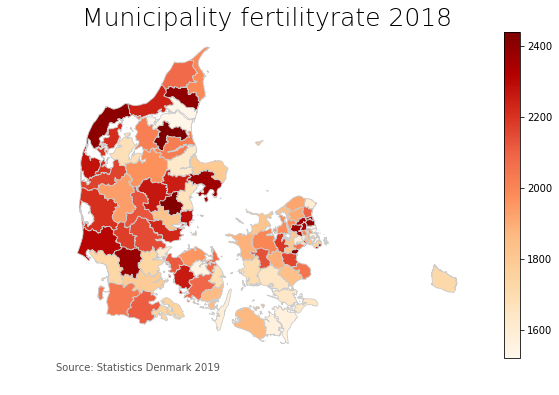

In [14]:
## With missings removed, Læsø, Samsø, Ærø, Fanø and Christiansø is lost.

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')

# add a title
ax.set_title('Municipality fertilityrate 2018', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

# create an annotation for the  data source
ax.annotate('Source: Statistics Denmark 2019',
           xy=(0.1, .08), xycoords='figure fraction',
           horizontalalignment='left', verticalalignment='top',
           fontsize=10, color='#555555')

## The actual plot is created
mergedNoMis.plot(column=VisVar,  cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')

## The color scale on the right is created in relation to the data
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

## The figure is saved in the folder
fig.savefig('testmap.png', dpi=300)

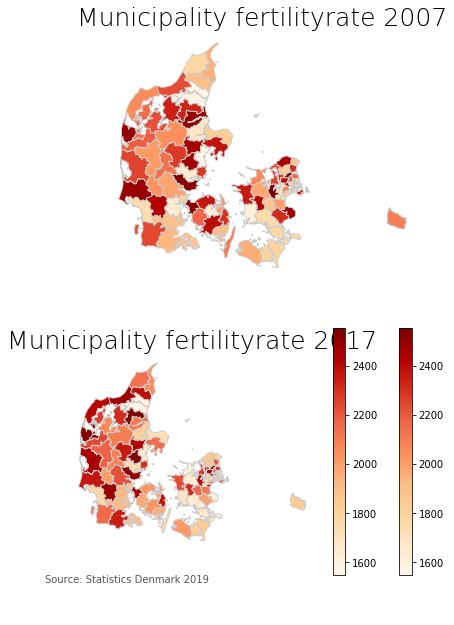

In [91]:
## With missings removed, Læsø, Samsø, Ærø, Fanø and Christiansø is lost.

# create figure and axes for Matplotlib
fig, (ax1, ax2) = plt.subplots(nrows=2,  figsize=(7,10))
ax1.axis('off')
ax2.axis('off')

# add a title
ax1.set_title('Municipality fertilityrate 2007', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

## The actual plot is created
mergedNoMis.plot(column=VisVar07,  cmap='OrRd', linewidth=0.8, ax=ax1, edgecolor='0.8')


# create an annotation for the  data source
ax1.annotate('Source: Statistics Denmark 2019',
           xy=(0.1, .08), xycoords='figure fraction',
           horizontalalignment='left', verticalalignment='top',
           fontsize=10, color='#555555')


# add a title
ax2.set_title('Municipality fertilityrate 2017', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})



## The actual plot is created
mergedNoMis.plot(column=VisVar17,  cmap='OrRd', linewidth=0.8, ax=ax2, edgecolor='0.8')

## The color scale on the right is created in relation to the data
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)




## The figure is saved in the folder
fig.savefig('testmap.png', dpi=300)

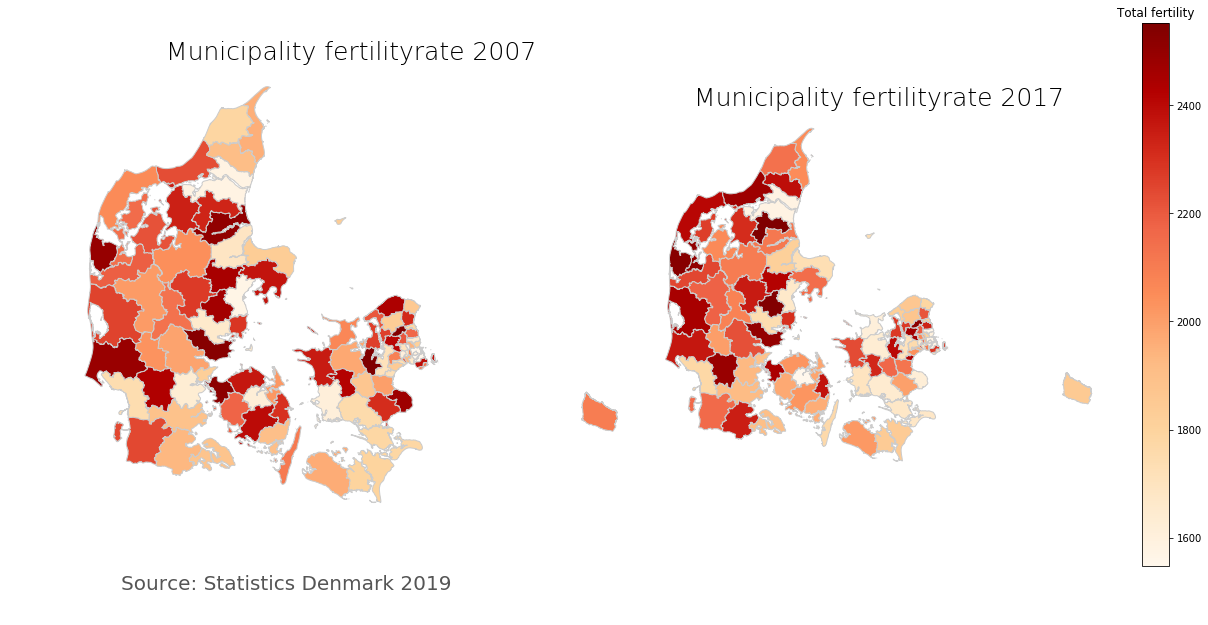

In [90]:
## With missings removed, Læsø, Samsø, Ærø, Fanø and Christiansø is lost.

# create figure and axes for Matplotlib

side_length = 10
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(side_length * 2.1, side_length) , subplot_kw={'aspect': 1})
fig.subplots_adjust(hspace=0.0, wspace=0.0)


ax1.axis('off')
ax2.axis('off')






# add a title
ax1.set_title('Municipality fertilityrate 2007', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})






## The actual plot is created
ax1=mergedNoMis.plot(column=VisVar07,  cmap='OrRd', ax=ax1, edgecolor='0.8')
ax1.set_aspect('equal')

# create an annotation for the  data source
ax1.annotate('Source: Statistics Denmark 2019',
           xy=(0.1, .08), xycoords='figure fraction',
           horizontalalignment='left', verticalalignment='top',
           fontsize=20, color='#555555')


# add a title
ax2.set_title('Municipality fertilityrate 2017', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})



## The actual plot is created
ax2=mergedNoMis.plot(column=VisVar17,  cmap='OrRd', ax=ax2, edgecolor='0.8')
ax2.set_aspect('equal')


## The color scale on the right is created in relation to the data
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

cbar.ax.set_title('Total fertility')



plt.show()

## The figure is saved in the folder
fig.savefig('testmap.png', dpi=300)